# ML_Modeling

In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../scripts')))
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

In [2]:
import warnings
warnings.filterwarnings('ignore')
import dvc.api

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as scs
import random
import math
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
from sklearn import tree
import scipy.stats as stat
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingClassifier




In [4]:
#import local modules
import Graphs
from Decision_tree import handler
from Decision_tree import DecisionTreesModel

from XGB import boost
from logistic_regression import Logistic

In [5]:
df= pd.read_csv("../data/AdSmartABdata_o.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


In [6]:
#Users who actually responded yes/no to the question of awareness
answered_df = df.copy(deep=True)
answered_df = answered_df[answered_df['yes'] == 1].append(answered_df[answered_df['no'] == 1])
answered_df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1,0
45,018af862-486e-4da1-a85b-71872120e57c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,1,0
65,023ec7b5-cb8f-49a5-995f-e0d7c2f702e5,exposed,2020-07-09,13,Samsung SM-G935F,6,Facebook,1,0
89,02efdb70-8596-4f3f-b0b2-b91e194f61f7,exposed,2020-07-05,6,Generic Smartphone,6,Chrome Mobile,1,0


In [7]:
control_df = answered_df[answered_df['experiment'] == 'control']
exposed_df = answered_df[answered_df['experiment'] == 'exposed']

In [8]:
all_yes_df = answered_df[answered_df['yes'] == 1].append(exposed_df[exposed_df['yes'] == 1])
all_yes_df = all_yes_df.drop(['yes','no'], axis = 1)
all_yes_df['response'] = 1
#All users who answered no
all_no_df = answered_df[answered_df['no'] == 1].append(exposed_df[exposed_df['no'] == 1])
all_no_df = all_no_df.drop(['yes','no'], axis = 1)
all_no_df['response'] = 0
#Final Combined dataframe will be
combined_df = all_yes_df.append(all_no_df)
combined_df = combined_df.sample(frac=1).reset_index(drop=True)
combined_df.head(5)

,auction_id,experiment,date,hour,device_make,platform_os,browser,response
0,5b22bcb4-f741-423b-9669-8c67ad123492,exposed,2020-07-09,12,Generic Smartphone,6,Chrome Mobile,0
1,3d126856-74a9-4921-8ae8-2350705b7db5,control,2020-07-03,15,Samsung SM-A715F,6,Facebook,1
2,fb546a62-59f9-4d47-ae03-818e38f90107,control,2020-07-09,8,POT-LX1,6,Facebook,0
3,b62683b9-dd40-4825-a97f-3c999dd85247,exposed,2020-07-05,18,Generic Smartphone,6,Chrome Mobile,1
4,5b22bcb4-f741-423b-9669-8c67ad123492,exposed,2020-07-09,12,Generic Smartphone,6,Chrome Mobile,0


# Encoding and Transforming

In [9]:
def encode_labels(df):
    date_encoder = preprocessing.LabelEncoder()
    device_encoder = preprocessing.LabelEncoder()
    browser_encoder = preprocessing.LabelEncoder()
    experiment_encoder = preprocessing.LabelEncoder()
    response_encoder = preprocessing.LabelEncoder()
    
    combined_df['date'] = date_encoder.fit_transform(combined_df['date'])
    combined_df['device_make'] = device_encoder.fit_transform(combined_df['device_make'])
    combined_df['browser'] = browser_encoder.fit_transform(combined_df['browser'])
    combined_df['experiment'] = experiment_encoder.fit_transform(combined_df['experiment'])
    combined_df['browser'] = response_encoder.fit_transform(combined_df['browser'])
    combined_df['response'] = response_encoder.fit_transform(combined_df['response'])


    
    return combined_df

## split the data to platform and browser based


In [10]:
def feature_data(combined_df):
    browser_df = combined_df[["experiment", "hour", "date", 'device_make', 'browser', 'response']]
    platform_df = combined_df[["experiment", "hour", "date", 'device_make', 'platform_os', 'response']]
                                  
    return browser_df, platform_df


In [11]:
def save_encoded_df(encoded_df):
    
    browser_df, platfrom_df = feature_data(encoded_df)
    browser_df.to_csv('../data/browser.csv', index=False)
    platfrom_df.to_csv('../data/platform.csv', index=False)

In [ ]:
encoded_df = encode_labels(combined_df)
save_encoded_df(encoded_df)

# ML modeling

In [12]:
#define train and split testing function and best random state to produce same result for different run
def split_train_test(X, y, test_size=0.1):
    return train_test_split(X, y, test_size=test_size, random_state=42)

#### Platform

In [13]:
#reading the encoded data from saved split data
platform_df= pd.read_csv("../data/platform.csv")
platform_df.head()

,experiment,hour,date,device_make,platform_os,response
0,1,15,1,13,6,0
1,0,14,5,43,6,0
2,0,5,0,13,6,1
3,1,7,6,65,6,0
4,1,15,2,13,6,0


#### browser

In [14]:
browser_df= pd.read_csv("../data/browser.csv")
browser_df.head()

,experiment,hour,date,device_make,browser,response
0,1,15,1,13,1,0
1,0,14,5,43,4,0
2,0,5,0,13,1,1
3,1,7,6,65,4,0
4,1,15,2,13,1,0


## Decision Tree Model

In [15]:
def read_model(self, file_name):
    with open(f"../models/{file_name}.pkl", "rb") as f:
        self.logger.info(f"Model loaded from {file_name}.pkl")
        return pickle.load(f)

def write_model(self, file_name):
      with open(f"../models/{file_name}.pkl", "wb") as f:
          self.logger.info(f"Model dumped to {file_name}.pkl")
          pickle.dump(model, f)

### using platform

In [16]:
#using platform df
feature_cols = ["experiment", "hour", "date", 'device_make', 'platform_os']

X = platform_df[feature_cols]
y = platform_df[['response']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [17]:
decisionTreesModel = DecisionTreesModel(X_train, X_test,  y_train, y_test)

folds = 5
clf, acc_arr, loss_arr = decisionTreesModel.train(folds)

step 0: Validation Accuracy of DecisionTreesModel is: 0.603
step 0: Validation Loss of DecisionTreesModel is: 0.630

step 1: Validation Accuracy of DecisionTreesModel is: 0.571
step 1: Validation Loss of DecisionTreesModel is: 0.655

step 2: Validation Accuracy of DecisionTreesModel is: 0.500
step 2: Validation Loss of DecisionTreesModel is: 0.707

step 3: Validation Accuracy of DecisionTreesModel is: 0.529
step 3: Validation Loss of DecisionTreesModel is: 0.686

step 4: Validation Accuracy of DecisionTreesModel is: 0.525
step 4: Validation Loss of DecisionTreesModel is: 0.689



step 1: Test Accuracy of DecisionTreesModel is: 0.496
Test Metrics
              precision    recall  f1-score   support

           0       0.81      0.50      0.62       103
           1       0.16      0.45      0.24        22

    accuracy                           0.50       125
   macro avg       0.49      0.48      0.43       125
weighted avg       0.70      0.50      0.56       125

Loss on test data is: 0.710



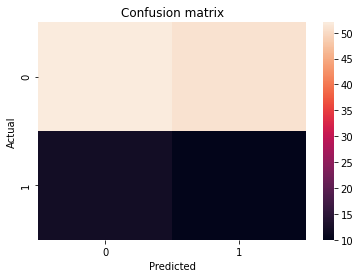

In [18]:
#Evaluating the model
test_acc, loss, report, confusion_matrix = decisionTreesModel.test()
print(f"Loss on test data is: {loss:.3f}")
print()

### Feature Importance

In [19]:
#quantifing the importance of the features(columns)
decisionTreesModel.get_feature_importance()

,feature,feature_importances
0,experiment,0.033768
1,hour,0.437571
2,date,0.285323
3,device_make,0.243338
4,platform_os,0.000000


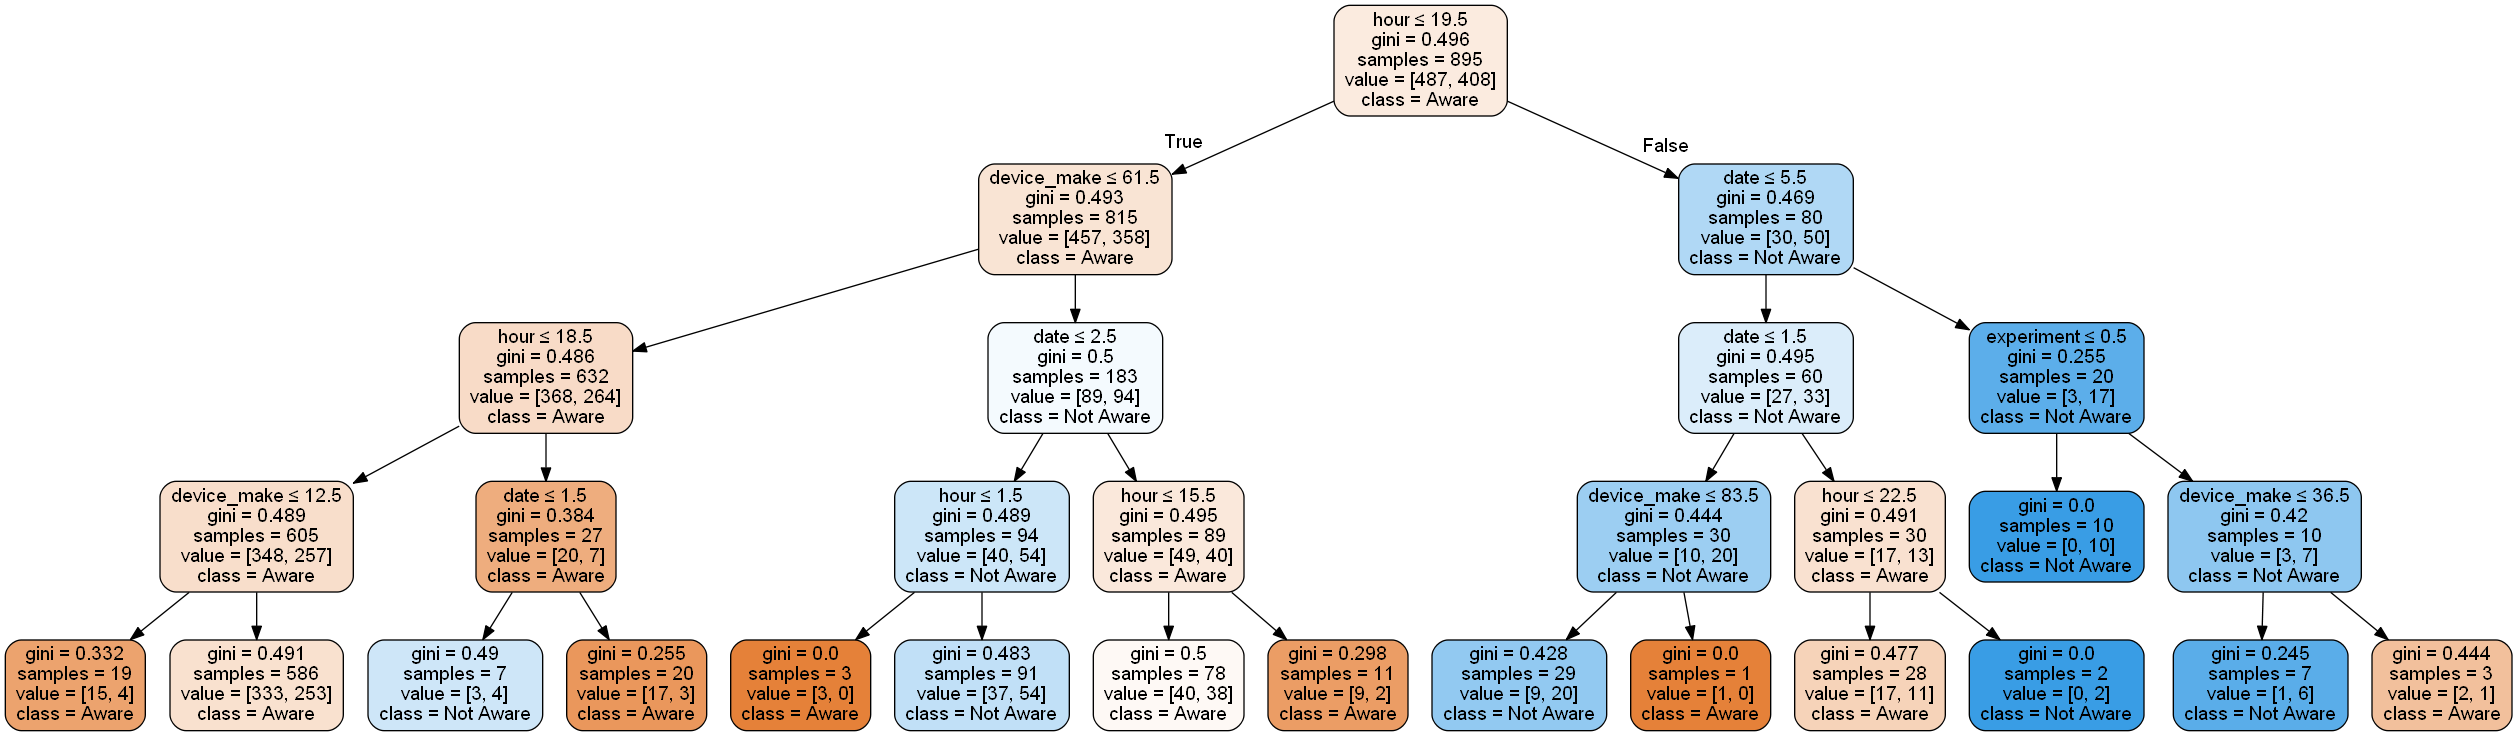

In [20]:
#visualization
dot_data = StringIO()

leaves_parallel=False
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']
out_put_file = "AbTestDecisionTree.dot"

dot_data = export_graphviz(clf, out_file=out_put_file,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['Aware','Not Aware'])

graph = pydotplus.graphviz.graph_from_dot_file(out_put_file)
graph.write_png('AbTestDecisionTree.png')
Image(graph.create_png())

### using Browser

In [21]:
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']

X = browser_df[feature_cols]
y = browser_df[['response']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [22]:
decisionTreesModel = DecisionTreesModel(X_train, X_test,  y_train, y_test)

folds = 5
clf, acc_arr, loss_arr = decisionTreesModel.train(folds)

step 0: Validation Accuracy of DecisionTreesModel is: 0.603
step 0: Validation Loss of DecisionTreesModel is: 0.630

step 1: Validation Accuracy of DecisionTreesModel is: 0.571
step 1: Validation Loss of DecisionTreesModel is: 0.655

step 2: Validation Accuracy of DecisionTreesModel is: 0.518
step 2: Validation Loss of DecisionTreesModel is: 0.694

step 3: Validation Accuracy of DecisionTreesModel is: 0.520
step 3: Validation Loss of DecisionTreesModel is: 0.693

step 4: Validation Accuracy of DecisionTreesModel is: 0.502
step 4: Validation Loss of DecisionTreesModel is: 0.706



step 1: Test Accuracy of DecisionTreesModel is: 0.512
Test Metrics
              precision    recall  f1-score   support

           0       0.78      0.52      0.62        97
           1       0.23      0.50      0.31        28

    accuracy                           0.51       125
   macro avg       0.51      0.51      0.47       125
weighted avg       0.66      0.51      0.55       125

Loss on test data is: 0.699
Test accuracy on test data is: 0.512



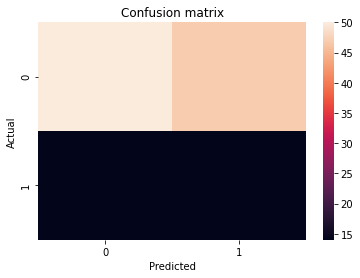

In [23]:
#evaluating the model
test_acc, loss, report, confusion_matrix = decisionTreesModel.test()
print(f"Loss on test data is: {loss:.3f}")
print(f"Test accuracy on test data is: {test_acc:.3f}")
print()

In [24]:
#quantifing the importance of the features(columns)
decisionTreesModel.get_feature_importance()

,feature,feature_importances
0,experiment,0.033264
1,hour,0.383416
2,date,0.252617
3,device_make,0.173131
4,browser,0.157572


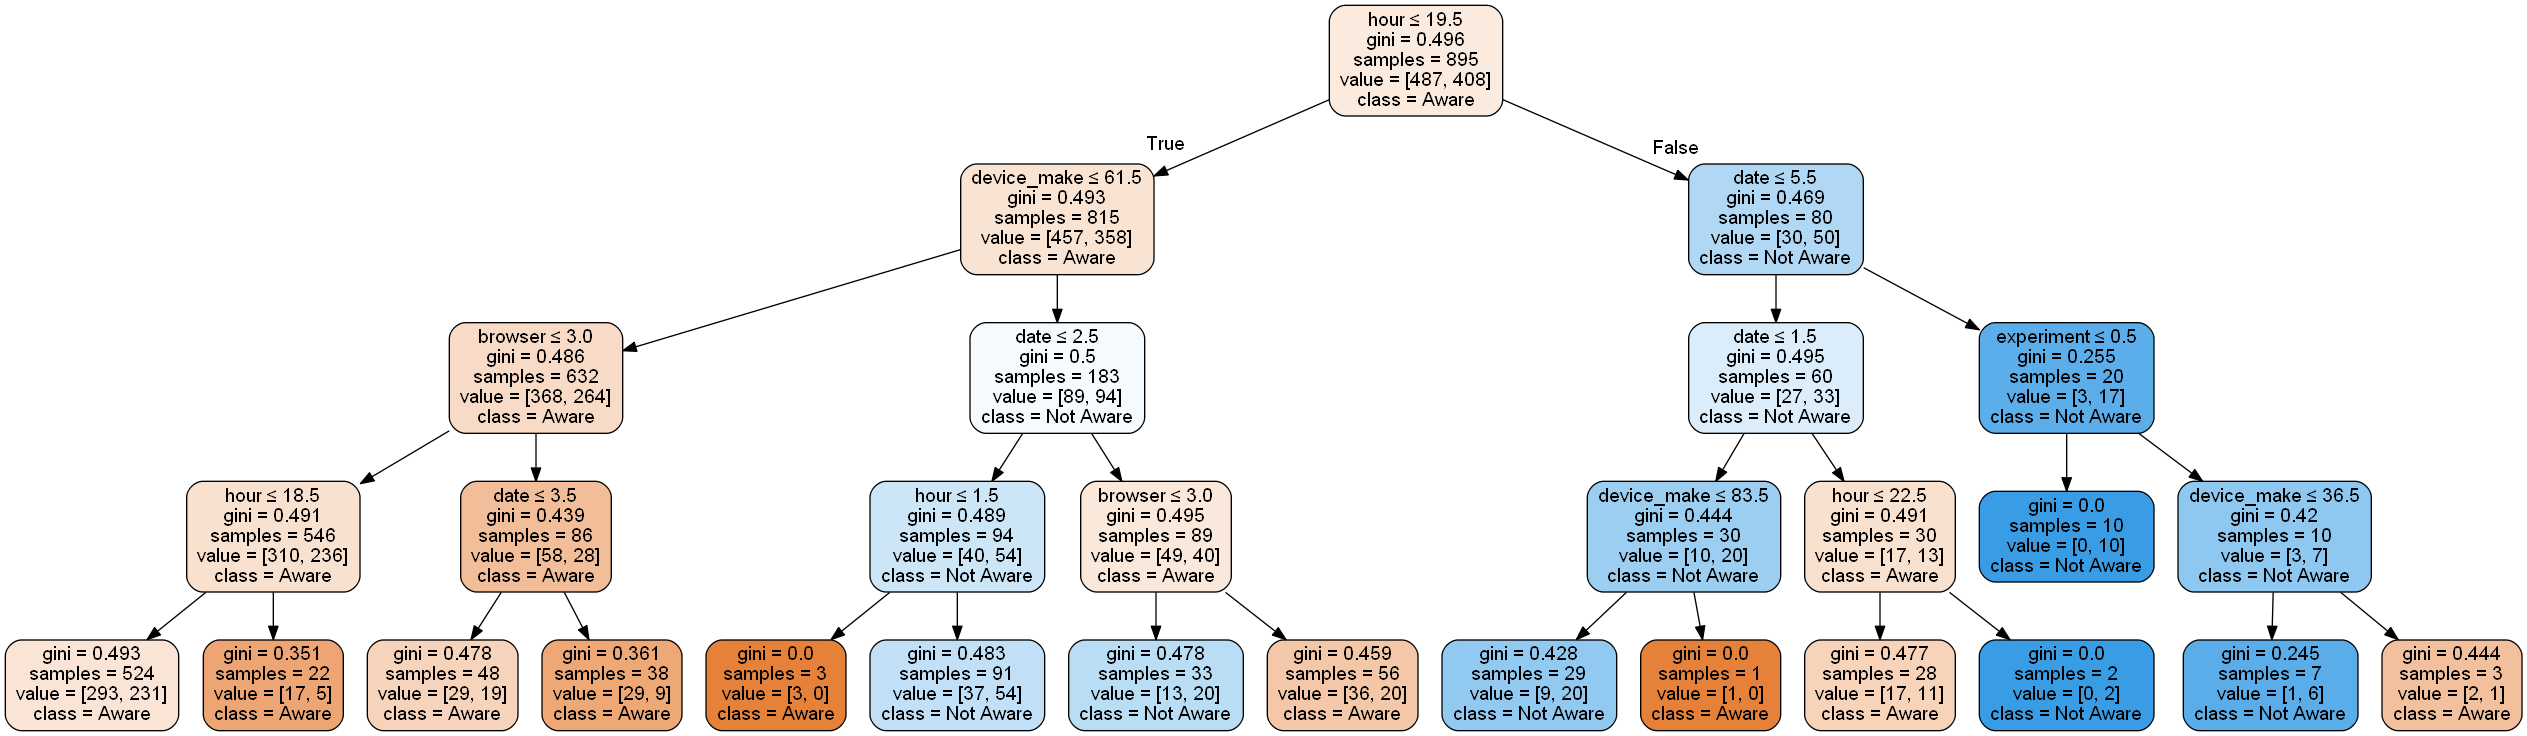

In [25]:
#visualization
dot_data = StringIO()

leaves_parallel=False
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']
out_put_file = "AbTestDecisionTree.dot"

dot_data = export_graphviz(clf, out_file=out_put_file,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['Aware','Not Aware'])

graph = pydotplus.graphviz.graph_from_dot_file(out_put_file)
graph.write_png('AbTestDecisionTree.png')

Image(graph.create_png())

## Logistic Regression

### using Browser

In [26]:
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']

X = browser_df[feature_cols]
y = browser_df[['response']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [27]:
logisticRegressionModel = Logistic(X_train, X_test,  y_train, y_test)

folds = 5
clf2, loss_arr_2, acc_arr_2 = logisticRegressionModel.train(folds)

step 0: Validation Accuracy of LogesticRegression is: 0.571
step 0: Validation Loss of LogesticRegression is: 0.655

step 1: Validation Accuracy of LogesticRegression is: 0.616
step 1: Validation Loss of LogesticRegression is: 0.620

step 2: Validation Accuracy of LogesticRegression is: 0.522
step 2: Validation Loss of LogesticRegression is: 0.691

step 3: Validation Accuracy of LogesticRegression is: 0.534
step 3: Validation Loss of LogesticRegression is: 0.683

step 4: Validation Accuracy of LogesticRegression is: 0.561
step 4: Validation Loss of LogesticRegression is: 0.663



step 1: Test Accuracy of LogesticRegression is: 0.504
Test Metrics
              precision    recall  f1-score   support

           0       0.84      0.51      0.64       106
           1       0.15      0.47      0.23        19

    accuracy                           0.50       125
   macro avg       0.50      0.49      0.43       125
weighted avg       0.74      0.50      0.57       125



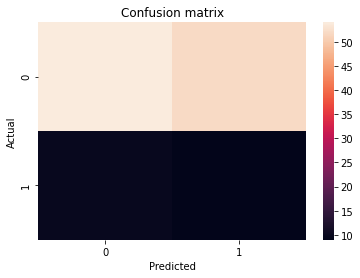

In [28]:
test_acc2, test_loss2, report2, matrix2  = logisticRegressionModel.test()

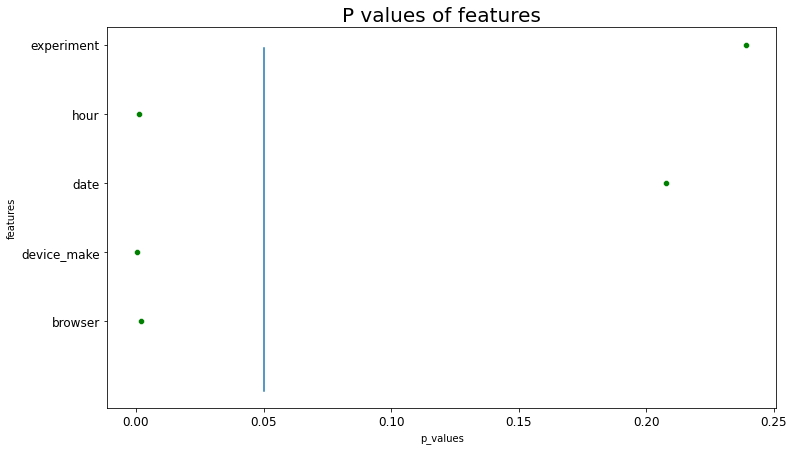

,features,p_values
0,experiment,0.239141
1,hour,0.001165
2,date,0.207942
3,device_make,0.000488
4,browser,0.001972


In [29]:
p_values_df = logisticRegressionModel.get_p_values()
p_value_fig = logisticRegressionModel.plot_pvalues(p_values_df)
p_values_df


### using Platform

In [30]:
feature_cols = ["experiment", "hour", "date", 'device_make', 'platform_os']

X = platform_df[feature_cols]
y = platform_df[['response']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [31]:
logesticRegressionModel = Logistic(X_train, X_test,  y_train, y_test)

folds = 5
clf2, loss_arr_2, acc_arr_2 = logesticRegressionModel.train(folds)

step 0: Validation Accuracy of LogesticRegression is: 0.594
step 0: Validation Loss of LogesticRegression is: 0.637

step 1: Validation Accuracy of LogesticRegression is: 0.589
step 1: Validation Loss of LogesticRegression is: 0.641

step 2: Validation Accuracy of LogesticRegression is: 0.527
step 2: Validation Loss of LogesticRegression is: 0.688

step 3: Validation Accuracy of LogesticRegression is: 0.502
step 3: Validation Loss of LogesticRegression is: 0.706

step 4: Validation Accuracy of LogesticRegression is: 0.538
step 4: Validation Loss of LogesticRegression is: 0.680



step 1: Test Accuracy of LogesticRegression is: 0.488
Test Metrics
              precision    recall  f1-score   support

           0       0.81      0.50      0.62       104
           1       0.15      0.43      0.22        21

    accuracy                           0.49       125
   macro avg       0.48      0.46      0.42       125
weighted avg       0.70      0.49      0.55       125



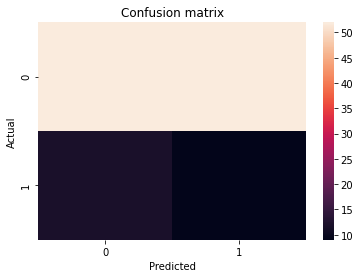

In [32]:
test_acc2, test_loss2, report2, matrix2  = logesticRegressionModel.test()

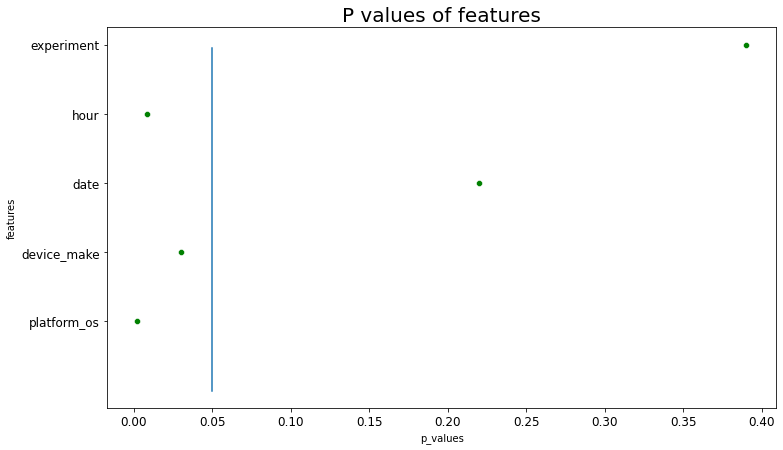

,features,p_values
0,experiment,0.389837
1,hour,0.008778
2,date,0.219600
3,device_make,0.029989
4,platform_os,0.002313


In [33]:
p_values_df = logesticRegressionModel.get_p_values()
p_value_fig = logesticRegressionModel.plot_pvalues(p_values_df)
p_values_df

## XGBOOST

### by browser

In [34]:
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']

X = browser_df[feature_cols]
y = browser_df[['response']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [35]:
xGBClassifierModel = boost(X_train, X_test,  y_train, y_test)

folds = 5
clf3, acc_arr, loss_arr = xGBClassifierModel.train(folds)

step 0: Validation Accuracy of GradientBoostingClassifier is: 0.554
step 0: Validation Loss of GradientBoostingClassifier is: 0.668

step 1: Validation Accuracy of GradientBoostingClassifier is: 0.554
step 1: Validation Loss of GradientBoostingClassifier is: 0.668

step 2: Validation Accuracy of GradientBoostingClassifier is: 0.518
step 2: Validation Loss of GradientBoostingClassifier is: 0.694

step 3: Validation Accuracy of GradientBoostingClassifier is: 0.547
step 3: Validation Loss of GradientBoostingClassifier is: 0.673

step 4: Validation Accuracy of GradientBoostingClassifier is: 0.507
step 4: Validation Loss of GradientBoostingClassifier is: 0.702



step 1: Test Accuracy of GradientBoostingClassifier is: 0.512
Test Metrics
              precision    recall  f1-score   support

           0       0.77      0.52      0.62        95
           1       0.25      0.50      0.33        30

    accuracy                           0.51       125
   macro avg       0.51      0.51      0.47       125
weighted avg       0.64      0.51      0.55       125

Loss on test data is: 0.699



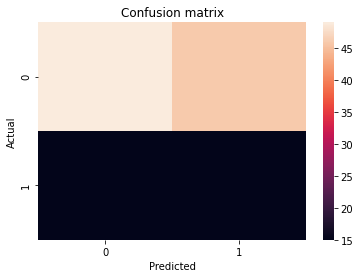

In [36]:
est_acc, loss, report, confusion_matrix = xGBClassifierModel.test()
print(f"Loss on test data is: {loss:.3f}")
print()

In [37]:
xGBClassifierModel.get_feature_importance()

,feature,feature_importances
0,experiment,0.040692
1,hour,0.345187
2,date,0.166472
3,device_make,0.337596
4,browser,0.110053


### by Platform

In [39]:
feature_cols = ["experiment", "hour", "date", 'device_make', 'platform_os']

X = platform_df[feature_cols]
y = platform_df[['response']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [41]:
xGBClassifierModel = boost(X_train, X_test,  y_train, y_test)

folds = 5
clf3, acc_arr, loss_arr = xGBClassifierModel.train(folds)

step 0: Validation Accuracy of GradientBoostingClassifier is: 0.527
step 0: Validation Loss of GradientBoostingClassifier is: 0.688

step 1: Validation Accuracy of GradientBoostingClassifier is: 0.549
step 1: Validation Loss of GradientBoostingClassifier is: 0.671

step 2: Validation Accuracy of GradientBoostingClassifier is: 0.540
step 2: Validation Loss of GradientBoostingClassifier is: 0.678

step 3: Validation Accuracy of GradientBoostingClassifier is: 0.511
step 3: Validation Loss of GradientBoostingClassifier is: 0.699

step 4: Validation Accuracy of GradientBoostingClassifier is: 0.502
step 4: Validation Loss of GradientBoostingClassifier is: 0.706



step 1: Test Accuracy of GradientBoostingClassifier is: 0.512
Test Metrics
              precision    recall  f1-score   support

           0       0.72      0.52      0.60        89
           1       0.30      0.50      0.37        36

    accuracy                           0.51       125
   macro avg       0.51      0.51      0.49       125
weighted avg       0.60      0.51      0.54       125

Loss on test data is: 0.699



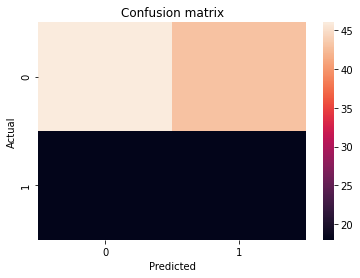

In [42]:
test_acc, loss, report, confusion_matrix = xGBClassifierModel.test()
print(f"Loss on test data is: {loss:.3f}")
print()

# Hyperparamerter Tuning for Decision Tree